Test using NCAR LENS tasmax using dask on scylla using kernel gloenv_py3.9
====

module load python/gloenv3.9

Example of an analysis of gridded ensemble temperature estimates over the whole globe

by [Laurent Terray](https://github.com/jhamman/)


For this example, we'll open a 5 member ensemble of maximum temperature data. Each ensemble member is stored in a seperate netCDF file and are otherwise formatted identically. The analysis we do below is very simple but the problem is a good illustration of an IO bound task.

In [1]:

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)


In [2]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
indir_data = '/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/DASK_LT/'
dirloc_scylla = indir_data+'TESTS-JUPYTER_NOTEBOOKS/'
print(indir_data)
print(dirloc_scylla)

/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/
/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/TESTS-JUPYTER_NOTEBOOKS/


### Connect to Dask Distributed Cluster : launch Dask with dask-jobqueue
The Dask-jobqueue project makes it easy to deploy Dask on common job queuing systems typically found in high performance supercomputers, academic research institutions, and other clusters. It provides a convenient interface that is accessible from interactive systems like Jupyter notebooks, or batch jobs.

In [4]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = SLURMCluster(local_directory = dirloc_scylla,
                       cores=4,
                       processes=1,
                       memory="5GB",
                       queue='bigmem'
                       walltime='2:00:00')
cluster.scale(2)
client = Client(cluster)

### Open the dataset using Xarray

Here we open the 5 member ensemble. Each ensemble member is stored as a single file and we use `xarray.open_mfdataset` to concatenate them along a new `ensemble` dimension. In addition to chunking along the `ensemble` dimension (defaults to 1 chunk per file), we'll also chunk along the `time` dimension. 

In [5]:
ds = xr.open_mfdataset(indir_data+'tasmax_day_CESM1_r*.nc',
                       engine='netcdf4', concat_dim='ensemble', combine='nested', chunks={'time': 365})

#### Metadata
Let's start by printing some metadata before we get started with the fun


In [6]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds.info()

ds size in GB 73.07

xarray.Dataset {
dimensions:
	time = 66065 ;
	ensemble = 5 ;
	bnds = 2 ;
	lon = 288 ;
	lat = 192 ;

variables:
	object time(time) ;
		time:standard_name = time ;
		time:long_name = time ;
		time:bounds = time_bnds ;
		time:axis = T ;
	object time_bnds(ensemble, time, bnds) ;
	float64 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
		lon:axis = X ;
	float64 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
		lat:axis = Y ;
	float32 tasmax(ensemble, time, lat, lon) ;
		tasmax:long_name = Maximum reference height temperature over output period ;
		tasmax:units = K ;
		tasmax:cell_methods = time: maximum ;

// global attributes:
	:CDI = Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/cdi) ;
	:history = Mon Apr 15 16:33:35 2019: cdo selvar,tasmax /scratch/globc/terray/cmip6/primavera/NCAR/CESM1-ALL/day/tasmax/tasmax_day_CESM1_historical_all_r1i1p1f1_19

### Look! All these arrays are dask arrays under the hood. Note the chunk sizes


In [7]:
for name, da in ds.data_vars.items():
    print(name, da.data)

time_bnds dask.array<concatenate, shape=(5, 66065, 2), dtype=object, chunksize=(1, 365, 2), chunktype=numpy.ndarray>
tasmax dask.array<concatenate, shape=(5, 66065, 192, 288), dtype=float32, chunksize=(1, 365, 192, 288), chunktype=numpy.ndarray>


### Get monthly means
We can just use resample with frequency Month.


### Intra-ensemble range
We can start by calculating the intra-ensemble range for all the mean daily temperature in this dataset.


In [8]:
# calculates the long term mean along the time dimension
da_mean = ds['tasmax'].mean(dim='time')
# calculate the intra-ensemble range of long term means
da_spread = da_mean.max(dim='ensemble') - da_mean.min(dim='ensemble')
da_spread

<xarray.DataArray 'tasmax' (lat: 192, lon: 288)>
dask.array<sub, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0

### Calling compute
The expressions above didn't actually compute anything. They just build the dask task graph. To do the computations, we call the `compute` method:

In [9]:
%time da_spread = da_spread.compute()

CPU times: user 2.85 s, sys: 306 ms, total: 3.16 s
Wall time: 34.4 s


#### Figure: Intra-ensemble range


Text(0.5, 1.0, 'Intra-ensemble range in maximum temperature')

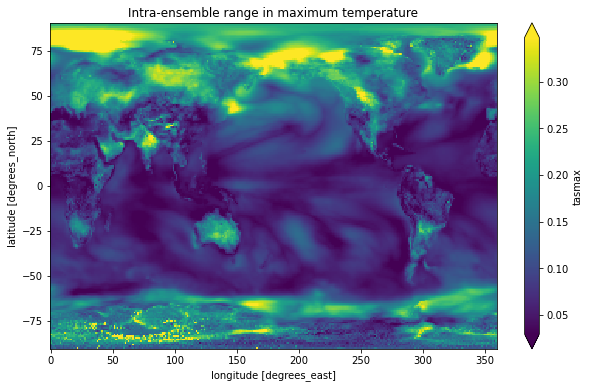

In [10]:
da_spread.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in maximum temperature')

### Persisting data on the cluster

(Make sure you have well over 300GB of RAM on your cluster, you can change the `ensemble=slice(0, 25)` section below to use more/less ensemble members.

Most of the time spent in the last calculation was loading data from disk.  After we were done with this data, Dask threw it away to free up memory.  If we plan to reuse the same dataset many times then we may want to `persist` it in memory.

In [14]:
t_mean = ds['tasmax'].isel(ensemble=slice(0, 4))
t_mean = t_mean.persist()
t_mean

<xarray.DataArray 'tasmax' (ensemble: 4, time: 66065, lat: 192, lon: 288)>
dask.array<getitem, shape=(4, 66065, 192, 288), dtype=float32, chunksize=(1, 365, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1920-01-01 00:00:00 ... 2100-12-31 00:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Dimensions without coordinates: ensemble
Attributes:
    long_name:     Maximum reference height temperature over output period
    units:         K
    cell_methods:  time: maximum

Now the t_mean DataArray is resident in memory on our workers.  We can repeat our computation from last time much more quickly.

In [15]:
%%time
temp_mean = t_mean.mean(dim='time')
spread = temp_mean.max(dim='ensemble') - temp_mean.min(dim='ensemble')  # calculates the intra-ensemble range of long term means
mean = spread.compute()

CPU times: user 1.52 s, sys: 187 ms, total: 1.71 s
Wall time: 1min 3s


Text(0.5, 1.0, 'Intra-ensemble range in mean annual temperature')

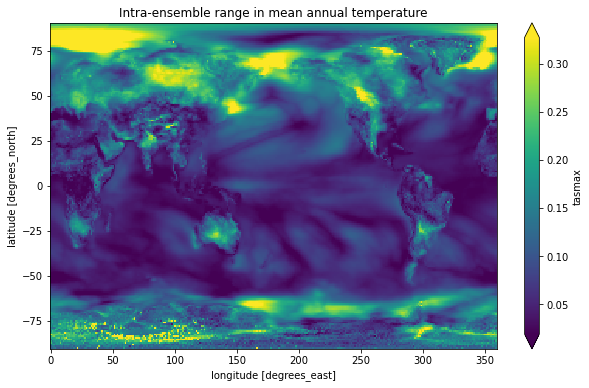

In [16]:
mean.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in mean annual temperature')

And we can also modify the computation and try something new.  Keeping data in memory allows to *iterate quickly*, which is the whole point of this exercise.

In [17]:
%%time
temp_mean = t_mean.std(dim='time')
spread = temp_mean.max(dim='ensemble') - temp_mean.min(dim='ensemble')  # calculates the intra-ensemble range of long term means
std = spread.compute()

CPU times: user 1.78 s, sys: 228 ms, total: 2.01 s
Wall time: 1min 10s


Text(0.5, 1.0, 'Intra-ensemble range in standard deviation of annual temperature')

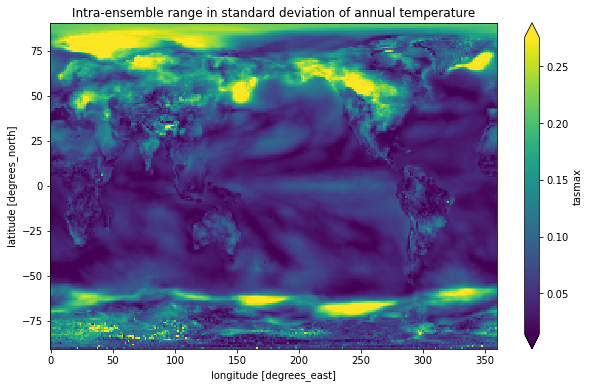

In [18]:
std.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in standard deviation of annual temperature')